In [1]:
# All imports

import numpy as np
import os
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import torch as th
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.manifold import TSNE

In [55]:
# Declare encoder decoder and Unet

class Encoder(nn.Module):
    
    def __init__(self, n_layers=5, root_features=8, expansion_factor=2):
        super().__init__()
        self.output_channels = [root_features]
        conv_i = []
        bn_i = []
        for i in range(n_layers):
            in_ch, out_ch = self.output_channels[-1], self.output_channels[-1]*expansion_factor 
            conv_i += [ nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False) ]
            bn_i += [ nn.BatchNorm2d(out_ch) ]
            self.output_channels += [out_ch]
        self.conv_i = nn.ModuleList(conv_i)
        self.bn_i = nn.ModuleList(bn_i)
        self.act = nn.LeakyReLU(inplace=True)
        
    def forward(self,x):
        outputs = [x]
        for bn,conv in zip(self.bn_i,self.conv_i):
            x = self.act(bn(conv(x)))
            outputs += [x]
            x = x[:,:,::2,::2]
        return outputs
    
class Decoder(nn.Module):
    
    def __init__(self, encoder_n_layers=5, encoder_root_features=8, encoder_expansion_factor=2, skip=True):
        super().__init__()
        self.output_channels = [encoder_root_features*encoder_expansion_factor**encoder_n_layers]
        self.skip = skip
        self.encoder_n_layers = encoder_n_layers
        upconv_i = []
        conv_i = []
        bn_i = []
        for i in range(encoder_n_layers-1):
            in_ch, out_ch = self.output_channels[-1], self.output_channels[-1]//encoder_expansion_factor 
            upconv_i += [ nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2*2, stride=2, padding=1) ]
            conv_i += [ nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False) ]
            bn_i += [ nn.BatchNorm2d(out_ch) ]
            self.output_channels += [out_ch]
        self.upconv_i = nn.ModuleList(upconv_i)
        self.bn_i = nn.ModuleList(bn_i)
        self.conv_i = nn.ModuleList(conv_i)
        self.act = nn.LeakyReLU(inplace=True)
        
    def forward(self,encoder_outputs):
        x = encoder_outputs[-1]
        for i in range(self.encoder_n_layers-1):
            if self.skip : 
                x = self.act(self.upconv_i[i](x) + encoder_outputs[-(i+2)])
            else : 
                x = self.act(self.upconv_i[i](x))
            x = self.act(self.bn_i[i](self.conv_i[i](x)))
        return x
    
class Unet(nn.Module):
    
    def __init__(self, input_channels, output_channels, n_layers=5, root_features=8, expansion_factor=2, skip=True):
        super().__init__()
        self.skip = skip
        self.encoder = Encoder(n_layers=n_layers, root_features=root_features, expansion_factor=expansion_factor)
        self.decoder = Decoder(encoder_n_layers=n_layers, encoder_root_features=root_features, encoder_expansion_factor=expansion_factor, skip=skip)
        self.conv_in = nn.Conv2d(input_channels, root_features, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(self.decoder.output_channels[-1], output_channels, kernel_size=3, padding=1)
        
    def encode(self,x):
        outputs = self.encoder(self.conv_in(x))
        context = outputs[-1]
        return context
    
    def decode(self, context):
        x = self.conv_out(self.decoder([context]))
        return x
    
    def forward(self,x):
        outputs = self.encoder(self.conv_in(x))
        context = outputs[-1]
        if self.skip: x = self.conv_out(self.decoder(outputs[-1:]))
        else: x = self.conv_out(self.decoder(outputs))
        return x, context


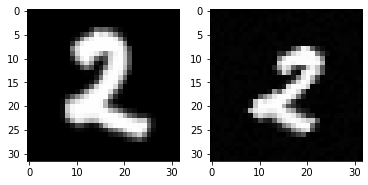

In [54]:
# define data pipeline for train and test

resize = torchvision.transforms.Resize([32,32])
random_affine = transforms.RandomAffine(degrees=[-10,10], translate=[0.06,0.06], scale=[0.8,1.2], shear=[-20,20])
color_jitter = transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.0, hue=0.0)
pil2tensor =  transforms.PILToTensor()
tensorfloat = transforms.ConvertImageDtype(th.float)

def transform(src_image):
    src_image = resize(src_image)
    src_image_tensor = tensorfloat(pil2tensor(src_image))
    dst_image = random_affine(src_image)
    dst_image = color_jitter(dst_image)
    dst_image_tensor = tensorfloat(pil2tensor(dst_image))
    dst_image_tensor += th.rand(dst_image_tensor.shape, dtype=dst_image_tensor.dtype)*0.01
    return src_image_tensor, dst_image_tensor

def test_transform(src_image):
    src_image = resize(src_image)
    src_image_tensor = tensorfloat(pil2tensor(src_image))
    return src_image_tensor
    
class NoisyMnist(th.utils.data.Dataset):
    def __init__(self, path='.', train=True):
        self.dataset = torchvision.datasets.MNIST('.', train=True, transform=transform, download=True)
        
    def __len__(self): return len(self.dataset)
        
    def __getitem__(self,idx):
        batch,_ = self.dataset[idx]
        x,y = batch
        return x,y
        
dataset = NoisyMnist('.', train=True)
lengths = [len(dataset)-100,100]
train_dataset, valid_dataset = th.utils.data.random_split(dataset, lengths)
test_dataset = torchvision.datasets.MNIST('.', train=True, transform=test_transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=10, shuffle=False)

In [ ]:
# Show samples
x, y  = train_dataset[np.random.randint(len(train_dataset))]
x, y = x.numpy().squeeze(), y.numpy().squeeze()
fig,axs = plt.subplots(1,2)
axs[0].imshow(x, cmap='gray')
axs[1].imshow(y, cmap='gray')

In [4]:
# Define trainer with train/valid folder structure

class TrainEvalTrainer(pl.Trainer):
    def __init__(self, *args,  train_logger=None, valid_logger=None, **kwargs ):
        self.train_logger = train_logger
        self.valid_logger = valid_logger
        self.validation_log = {}
        pl.Trainer.__init__(self, *args, **kwargs)
        
def create_trainer(log_path, max_epochs=50, auto_lr_find=True, gradient_clip_val=0, save_top_k=-1, check_val_every_n_epoch=1, gpus=1, gpu_choice='auto', limit_train_batches=1.):
    os.makedirs(log_path, exist_ok=True)
    train_logger = pl_loggers.TensorBoardLogger(os.path.join(log_path,'train'))
    valid_logger = pl_loggers.TensorBoardLogger(os.path.join(log_path,'valid'))
    checkpoint_callback = ModelCheckpoint(os.path.join(train_logger.log_dir, 'checkpoints'), save_top_k=save_top_k)
    trainer = TrainEvalTrainer( max_epochs=max_epochs, gpus=gpus, check_val_every_n_epoch=check_val_every_n_epoch, auto_lr_find=auto_lr_find, 
                                checkpoint_callback=checkpoint_callback, train_logger=train_logger, valid_logger=valid_logger, 
                                gradient_clip_val=gradient_clip_val, limit_train_batches=limit_train_batches, logger=False)
    
    return trainer

In [6]:
# Define trainer and main cllbacks

matplotlib.use('Agg')

class NTXentLoss(nn.Module):
    
    def __init__(self):
        super().__init__()

    def forward(self, hidden0, hidden1, temperature0=0.5, temperature1=1.5, normalize=True):
        if normalize:
            hidden0 = F.normalize(hidden0, p=2, dim=1)
            hidden1 = F.normalize(hidden1, p=2, dim=1)
        X = hidden0 @ hidden1.T
        I = th.eye(X.shape[0], device=X.device)
        n = X.shape[0]
        A = (1 - I)/(n-1)
        S = (I - A)*X
        lij = S.sum(axis=0) / temperature0
        lji = S.sum(axis=1) / temperature1
        logits = th.cat([lij, lji], axis=0)
        target = th.ones_like(logits, device=logits.device)
        loss = F.binary_cross_entropy_with_logits(logits, target)
        return loss  

def get_plot(output):
    # get first image of each batch
    src_x_0 = output['x'][0,0]
    dst_x_0 = output['y'][0,0]
    pred_src_x_0 = output['pred_y'][0,0]
    fig,axs = plt.subplots(1,3)
    axs[0].imshow(src_x_0)
    axs[0].set_title('x')
    axs[1].imshow(dst_x_0)
    axs[1].set_title('y')
    axs[2].imshow(pred_src_x_0)
    axs[2].set_title('pred_y')
    return fig

class TrainUnet(pl.LightningModule):
    
    def __init__(self, **kwargs):
        super().__init__()
        self.unet = Unet(1,1, skip=False)
        self.bxe = nn.BCEWithLogitsLoss()
        self.nxt = NTXentLoss()

    def forward(self, x):
        context = self.unet.encode(x)
        y = self.unet.decode(context)
        return y,context
    
    def training_epoch_end(self, outputs):
        loss = sum([output['loss'] for output in outputs])/len(outputs)
        self.trainer.train_logger.experiment.add_scalar('loss',loss,self.current_epoch)
        self.trainer.train_logger.experiment.flush()
            
    def validation_epoch_end(self, outputs):    
        for idx,output in enumerate(outputs):
            fig = get_plot(output)
            self.trainer.valid_logger.experiment.add_figure('{}'.format(idx), fig, global_step=self.trainer.current_epoch)
        loss = sum([output['loss'] for output in outputs])/len(outputs)
        self.trainer.valid_logger.experiment.add_scalar('loss',loss,self.current_epoch)
        self.trainer.valid_logger.experiment.flush()
            
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred_y, context_x = self(x)
        context_y = self.unet.encode(y)
        bs = context_x.shape[0]
        context_x = context_x.view(bs,-1)
        context_y = context_y.view(bs,-1)
        loss = self.bxe(pred_y.view(-1),y.view(-1)) + self.nxt(context_x, context_y)
        output = { 'x': x.clone().detach().cpu().numpy(), 
                   'y': y.clone().detach().cpu().numpy(), 
                   'pred_y': pred_y.clone().detach().cpu().numpy(), 'loss': loss }
        return output

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred_y, context_x = self(x)
        context_y = self.unet.encode(y)
        bs = context_x.shape[0]
        context_x = context_x.view(bs,-1)
        context_y = context_y.view(bs,-1)
        loss = self.bxe(pred_y.view(-1),y.view(-1)) + self.nxt(context_x, context_y)
        output = { 'x': x.clone().detach().cpu().numpy(), 
                   'y': y.clone().detach().cpu().numpy(), 
                   'pred_y': pred_y.clone().detach().cpu().numpy(), 'loss': loss }
        return output
    
    def configure_optimizers(self):
        optimizer = th.optim.Adam(self.unet.parameters(), lr=0.001,weight_decay=0.001)
        lr_scheduler = th.optim.lr_scheduler.StepLR(optimizer,1,gamma=0.99)
        return { 'optimizer': optimizer, 'lr_scheduler': lr_scheduler }



In [7]:
model = TrainUnet()
log_path = 'logs'
trainer = create_trainer(log_path, max_epochs=100, limit_train_batches=1.0, )
#trainer.fit(model, train_dataloader=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [ ]:
def load_lightning_module(checkpoint_path, model_class):
    ckpt = th.load(checkpoint_path)
    pretrained_dict = ckpt['state_dict']
    model = model_class()
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 
    # 3. load the new state dict
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [8]:
# Load checkpoint
VERSION = 0
EPOCH = 99
! ls logs/train/default/version_$VERSION/checkpoints/epoch=$EPOCH*

'logs/train/default/version_4/checkpoints/epoch=31-step=19167.ckpt'


In [10]:
# ckpt_path = <get the path that has been printed>
model = load_lightning_module(ckpt_path, TrainUnet)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [12]:
model.eval().cuda()
all_codes = []
all_labels = []
all_images = []
with th.no_grad():
    for batch in tqdm(test_dataloader):
        image, label = batch
        image = image.cuda()
        bs = image.shape[0]
        codes = model.unet.encode(image).view(bs,-1)
        all_codes += [codes.cpu()]
        all_images += [ image.cpu() ]
        all_labels += [ label ]

all_codes = th.cat(all_codes, axis=0)
all_labels = th.cat(all_labels, axis=0)
all_images = th.cat(all_images, axis=0)

100%|██████████| 600/600 [00:13<00:00, 45.81it/s]


In [49]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=250)
sample_labels = all_labels[::10]
sample_manifold = tsne.fit_transform(all_codes[::10])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.904s...
[t-SNE] Computed neighbors for 6000 samples in 10.199s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.002086
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.624252
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.0

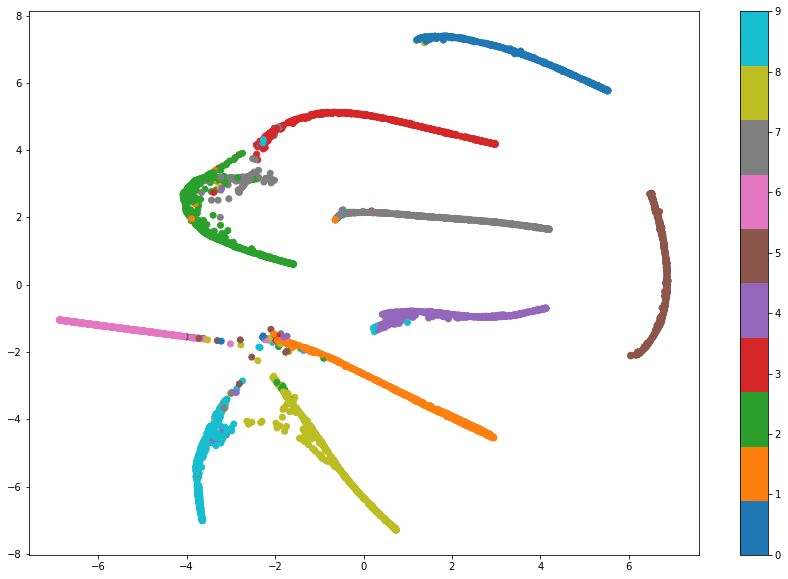

In [52]:
fig,axs = plt.subplots(1,1, figsize=(15,10))
_ = axs.scatter(sample_manifold[:,0],sample_manifold[:,1],c=sample_labels, cmap='tab10')
fig.colorbar(_)


In [15]:
test_logger = pl_loggers.TensorBoardLogger(os.path.join(log_path,'test'))
test_logger.experiment.add_embedding(all_codes, metadata=all_labels, label_img=all_images, global_step=None, tag='default', metadata_header=None)
